# Statistical Comparisons Generator

This notebook separates different measurement categories into numerous populations and compares the statistical significance of data trends

In [1]:
#all package imports needed for notebook here
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from scipy.stats import kruskal
import seaborn as sns
import numpy as np
import pprint as pp
from datetime import datetime
from IPython.display import display
import thinkstats2
import thinkplot

df2013 = pd.read_csv('Kwadella_winter_2013_cleaned.csv')
df2014 = pd.read_csv('Kwadella_winter_2014_cleaned.csv')

/home/mackenzie/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/mackenzie/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


First we're looking at an analysis of variance between 2014 and 2013 to see how significantly the years differed. We'll look at how the outdoor temperatures varied (as a soft control), then compare the year's pollutant concentrations  to get a read for how well the intervention reduced pollution. We'll do this again with diurnal plots to be sure. 

Cross correlation will let us track dusttraks vs PM2.5 vs PM10 vs CO concentrations and traking the rise and fall of each pollutant over the course of the entire winter. We're starting by just looking at the entire winter, then we may divide pollution measurements based on temperature deviation of a given day or by month

Kruskal is best for comparing one category of measurement at different time points to see if there is significant variance between those groups. for example:  Krusal done on dusttraks from the mean temp track, dusttraks from 1 sd colder than the mean, and dusttraks from 1 sd warmer than the mean. This measurement would tell us if there is variance in pollution between the three groups. This test could also be applied to 2013 vs 2014 dusttraks to find statistical significance in the differences in pollution before and after intervention

In [2]:
def get_datetime(s):
    """strips date and time from the already existing date column"""
    dt = datetime.strptime(s, "%m/%d/%y %H:%M")
    return dt

def daysSinceStart(df):
    """get time since epoch using a series for month and day
    takes in dataframe and returns the dataframe with an added colum for days since the beginning of data collection"""
    dayArray = np.array(df.Day)
    monthArray = np.array(df.Month)
    
    runningDays = []
    for day, month in zip(dayArray, monthArray):
        if month == 7:
            total_days = 0
        elif month == 8:
            total_days = 31 
        elif month == 9:
            total_days = 61
        else:
            raise ValueError 
        total_days = total_days + day
        runningDays.append(total_days)
    df['DayCount'] = pd.Series(runningDays, index = df.index)
    return df

#Daily Average Outdoor Temp
def compute_avg_temp(df):
    df['DailyAverageTemp'] = df['Temperature_(degC)'].mean()
    return df

#each minute's avg indoor temp
def compute_avg_val(df):
    df['AvgHouse'] = (df['H01-K-E'].mean()+ df['H02-K-N'].mean() + df['H03-K-S'].mean()+ df['H04-K-S'].mean()
                      + df['H05-K-N'].mean()+df['H06-K-N'].mean() + df['H10-K-N'].mean()
                      +df['H11-K-X'].mean()+ df['H12-K-N'].mean() + df['H15-K-S'].mean() +df['H17-K-N'].mean() 
                      + df['H18-K-S'].mean() + df['H20-K-S'].mean()
                      )/13
    return df

def preprocess(df):
    """runs the datetime and daysSinceStart helper functions
    takes and returns a dataframe"""
    res = df.copy()
    datetimes = res.Date.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Day'] = datetimes.apply(lambda dt: dt.day)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Year'] = datetimes.apply(lambda dt: dt.year)
    res = compute_avg_val(res)
    return res

In [3]:
df2013 = preprocess(df2013)
df2013 = daysSinceStart(df2013)
grouped = df2013.groupby('DayCount')
df2013 = grouped.apply(compute_avg_temp)
df2013 = compute_avg_temp(df2013)
df2013['Dusttraks_(mg/m3)']= df2013['Dusttraks_(mg/m3)']*0.14


df2014 = daysSinceStart(df2014)
grouped = df2014.groupby('DayCount')
df2014 = grouped.apply(compute_avg_temp)
df2014 = compute_avg_temp(df2014)
df2014['Dusttraks_(mg/m3)']= df2014['Dusttraks_(mg/m3)']*0.14

In [48]:
def GroupByDay(df,header, func=np.mean):
    """Groups header values by day and compute the daily mean for each category.
    df: DataFrame of environmental data
    returns: DataFrame of daily data
    """
    groups = df[['DayCount', headers]].groupby('DayCount')
    daily = groups.aggregate(func)
    daily['DayCount'] = daily.index
    return daily

def FillMissing(df,header, span = 5000):
    """Fills missing values with an exponentially weighted moving average.
    Resulting DataFrame has missing values of specified column filled in
    df: DataFrame of raw values 
    span: window size (sort of) passed to ewma
    returns: new series for the dataframe
    """
    ewma= pd.ewma(df[str(header)], span, ignore_na = True) #series
    print ewma.count() #problem is that there are nans in ewma that get passed down the line
    
    resid = (df[str(header)]-ewma).dropna() #series
    fake_data = ewma +thinkstats2.Resample(resid, len(df))
    df[str(header)].fillna(fake_data, inplace = True) 
    return df[str(header)]

def normalize(df, headers):
    """Normalizes values of a dataframe after filling missing values- see FillMissing
    df: dataframe of un-normalized integer only data
    headers: specifc columns to be compared to one another
    returns: now normalized dataframe of only the specified headers with missing values filled in"""
    
    normdf = df[headers].dropna()
    #for h in headers:
     #   normdf[str(h)]=FillMissing(df,h) 

    df_norm = (normdf-normdf.mean())/(normdf.max() - normdf.min())
    return df_norm

intHeadCorrList= [ 'Temperature_(degC)','Dusttraks_(mg/m3)', 'PM10_(ug/m3)','PM2.5_(ug/m3)','SO2_(ppb)','CO_(ppm)','NO_(ppb)',
                 'NO2_(ppb)','AvgHouse']
dfnorm13 = normalize(df2013, intHeadCorrList)

122525
123315
122525
122525
122525
122525
122525
122525
125355


/home/mackenzie/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
#need this to return 0 for every column
dfnorm13.count()

Temperature_(degC)    122525
Dusttraks_(mg/m3)     123315
PM10_(ug/m3)          122525
PM2.5_(ug/m3)         122525
SO2_(ppb)             122525
CO_(ppm)              122525
NO_(ppb)              122525
NO2_(ppb)             122525
AvgHouse              125355
dtype: int64

In [29]:
#creating a dataframe with the spearman correlation for everything crossing one another
speardf = dfnorm13.corr(method = 'spearman')
print speardf.head()

                    Temperature_(degC)  Dusttraks_(mg/m3)  PM10_(ug/m3)  \
Temperature_(degC)            1.000000          -0.051971      0.334552   
Dusttraks_(mg/m3)            -0.051971           1.000000      0.359603   
PM10_(ug/m3)                  0.334552           0.359603      1.000000   
PM2.5_(ug/m3)                -0.003481           0.246446      0.366330   
SO2_(ppb)                     0.314639           0.320246      0.484691   

                    PM2.5_(ug/m3)  SO2_(ppb)  CO_(ppm)  NO_(ppb)  NO2_(ppb)  \
Temperature_(degC)      -0.003481   0.314639 -0.253483 -0.064890   0.187605   
Dusttraks_(mg/m3)        0.246446   0.320246  0.135695  0.582362   0.410862   
PM10_(ug/m3)             0.366330   0.484691  0.220396  0.205098   0.461499   
PM2.5_(ug/m3)            1.000000   0.232282  0.312534  0.087900   0.319056   
SO2_(ppb)                0.232282   1.000000  0.282412  0.460925   0.763380   

                    AvgHouse  
Temperature_(degC)       NaN  
Dusttraks_(m

In [6]:
#need to replace nans with a rolling mean, then normalize, then correlate 

This code for a cross correlation heatmap taken from some helpful seaborn documentation from stanford: https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html

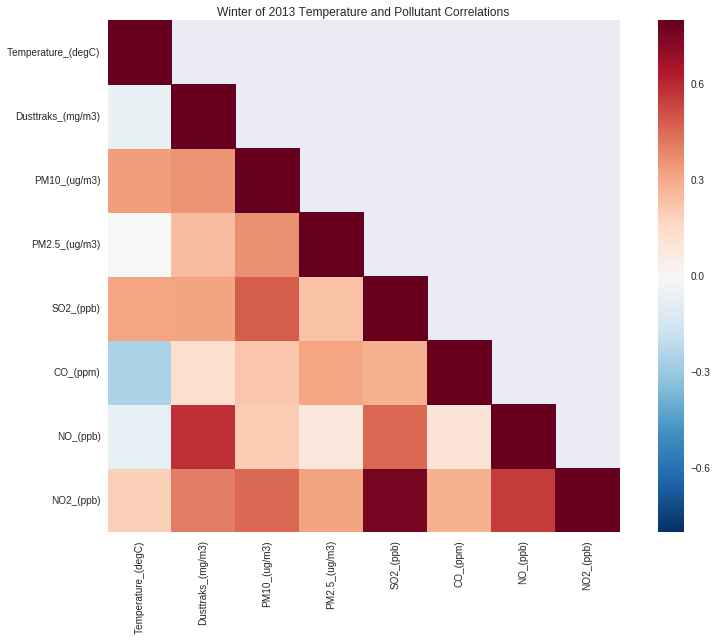

In [27]:

corrmat = speardf

mask = np.zeros_like(speardf, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat,mask=mask, vmax=.8, square=True)

plt.title('Winter of 2013 Temperature and Pollutant Correlations')
f.tight_layout()